# House Sale Price Prediction [Kaggle Problem](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview)

#### Problem Statement : **Predict house sale prices**

#### Metrics Used : RMSLE

#### Importing Libraries and reading the data

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.structured import *
import seaborn as sns
import matplotlib.pyplot as plt
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
import xgboost as xgb
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [3]:
PATH = "/home/shivangmathur/Downloads/house-prices-advanced-regression-techniques/"

In [4]:
df_raw = pd.read_csv(f'{PATH}train.csv', low_memory=False)

In [5]:
df_test = pd.read_csv(f'{PATH}test.csv', low_memory=False)

# Feature Engineering

**Creating new features**

In [6]:
df_raw['Age'] = df_raw['YrSold'] - df_raw['YearBuilt']
df_test['Age'] = df_test['YrSold'] - df_test['YearBuilt']

In [7]:
df_raw['Remodel Age'] = df_raw['YrSold'] - df_raw['YearRemodAdd']
df_test['Remodel Age'] = df_test['YrSold'] - df_test['YearRemodAdd']

In [8]:
df_raw.drop(['YrSold'], axis=1,inplace=True)
df_raw.drop(['YearBuilt'], axis=1,inplace=True)
df_raw.drop(['YearRemodAdd'], axis=1,inplace=True)
df_test.drop(['YrSold'], axis=1,inplace=True)
df_test.drop(['YearBuilt'], axis=1,inplace=True)
df_test.drop(['YearRemodAdd'], axis=1,inplace=True)
df_raw.drop(['GarageArea'], axis=1,inplace=True)
df_test.drop(['GarageArea'], axis=1,inplace=True)


In [9]:
df_raw['Quality'] = df_raw['OverallCond']+df_raw['OverallQual']
df_test['Quality'] = df_test['OverallCond']+df_test['OverallQual']

In [10]:
df_raw.drop(['OverallCond'], axis=1,inplace=True)
df_raw.drop(['OverallQual'], axis=1,inplace=True)
df_test.drop(['OverallCond'], axis=1,inplace=True)
df_test.drop(['OverallQual'], axis=1,inplace=True)

In [11]:
df_raw['Avg area of room'] = df_raw['GrLivArea']/df_raw['TotRmsAbvGrd']
df_test['Avg area of room'] = df_test['GrLivArea']/df_test['TotRmsAbvGrd']

**Converting into categorical values using train_cats and apply_cats techniques of fastai**

In [12]:
train_cats(df_raw)
apply_cats(df=df_test, trn=df_raw)

**Taking the log of the SalePrice as we need to calculate rmsle**

In [13]:
df_raw.SalePrice = np.log(df_raw.SalePrice)

**Handling with missing values and performing one hot encoding using proc_df technique of fastai**

In [14]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=30)
df_test2,_,nas= proc_df(df_test,max_n_cat=30,na_dict=nas)

In [15]:
df_trn2.drop(['Id'], axis=1,inplace=True)
df_test2.drop(['Id'], axis=1,inplace=True)

**Creating validation set**

In [16]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 350  
n_trn = len(df_trn2)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df_trn2, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
X_train.shape, y_train.shape, X_valid.shape

n_test = 100


**A function to calculate Root Mean Squared Logarithmic Error (RMSLE)**

In [17]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train),
           rmse(m.predict(X_valid), y_valid),
           m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

# Creating and comparing different Models

# 1. Random Forest

In [18]:

m = RandomForestRegressor(n_estimators=120, min_samples_leaf=1, 
                      max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train) 
print_score(m)

[0.051126540977615556, 0.13408599474427088, 0.9840166231447661, 0.8772651228225457, 0.879067475870035]


RMSLE in Random Forest : 0.13227153479706344

In [19]:
preds_log = m.predict(df_test2)
pred = np.expm1(preds_log)
pred
#Calculating predictions

array([122203.1086 , 150356.04613, 185264.59867, ..., 153936.96384, 125374.86555, 229603.63051])

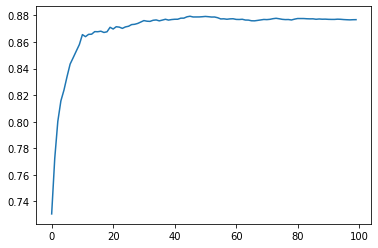

In [20]:
#Understanding how number of estimators will effect the perfomance
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
preds[:,0], np.mean(preds[:,0]), y_valid[0]
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(100)]);

# 2. LightGBM

In [21]:
import lightgbm as lgb
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.055, n_estimators=850,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 6, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
model_lgb.fit(X_train, y_train) 
print_score(model_lgb)

[0.06336699226388687, 0.12179076035781768, 0.9754471503395252, 0.8987418847332886]


RMSLE in Light GBM : 0.12468412714185853

In [22]:
preds_log = model_lgb.predict(df_test2)
pred2 = np.expm1(preds_log)
pred2
#Calculating predictions

array([123148.56115, 154271.55396, 184849.57149, ..., 163356.16423, 128242.21164, 208532.24301])

# 3. Sklearn's XgBoost

In [23]:
from xgboost import XGBRegressor
clf3= XGBRegressor(max_depth=9,learning_rate=0.07,subsample=.8,min_child_weight=3,colsample_bytree=.6,scale_pos_weight=1,
gamma=10,reg_alpha=6,reg_lambda=1.1)
# n_estimators = 100 (default)
# max_depth = 3 (default)
clf3.fit(X_train,y_train)
print_score(clf3)

[18:09:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0.24194788568719108, 0.23183511849800476, 0.6420524618492248, 0.6330899536241574]


RMSLE in XgBoost : 0.23183511849800476




# 4. Native XgBoost

In [24]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_valid, label=y_valid)

params = {
    'booster': 'gbtree', 
    'objective': 'reg:squarederror', # regression task
    'subsample': 0.8, # 80% of data to grow trees and prevent overfitting
    'colsample_bytree': 0.89, # 89% of features used
    'eta': 0.1,
    'gamma':0,
    'max_depth': 10,
    'seed': 42} # for reproducible results
params['eval_metric'] = "rmse"
num_boost_round = 999


# 4.1 Simple XgBoost

In [25]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[0]	Test-rmse:10.3787
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:9.34375
[2]	Test-rmse:8.41203
[3]	Test-rmse:7.57384
[4]	Test-rmse:6.81947
[5]	Test-rmse:6.13909
[6]	Test-rmse:5.52866
[7]	Test-rmse:4.9762
[8]	Test-rmse:4.48251
[9]	Test-rmse:4.03498
[10]	Test-rmse:3.6347
[11]	Test-rmse:3.27502
[12]	Test-rmse:2.94913
[13]	Test-rmse:2.65514
[14]	Test-rmse:2.39159
[15]	Test-rmse:2.15507
[16]	Test-rmse:1.94306
[17]	Test-rmse:1.75047
[18]	Test-rmse:1.57653
[19]	Test-rmse:1.41996
[20]	Test-rmse:1.28011
[21]	Test-rmse:1.15402
[22]	Test-rmse:1.04224
[23]	Test-rmse:0.942506
[24]	Test-rmse:0.850774
[25]	Test-rmse:0.770433
[26]	Test-rmse:0.69721
[27]	Test-rmse:0.632528
[28]	Test-rmse:0.573333
[29]	Test-rmse:0.521692
[30]	Test-rmse:0.473854
[31]	Test-rmse:0.431484
[32]	Test-rmse:0.393698
[33]	Test-rmse:0.360238
[34]	Test-rmse:0.329711
[35]	Test-rmse:0.304281
[36]	Test-rmse:0.280895
[37]	Test-rmse:0.259735
[38]	Test-rmse:0.242262
[39]	Test-rmse:0.22585
[40]	Test-rmse:0.212

RMSLE in Simple XgBoost : 0.123834

# 4.2 XgBoost with cross validation

In [26]:
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=5,
    metrics={'rmse'},
    early_stopping_rounds=10
)
cv_results

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,10.381735,0.003938,10.381722,0.016387
1,9.346777,0.003399,9.346762,0.016944
2,8.414673,0.003186,8.414658,0.017154
3,7.576957,0.003020,7.576942,0.017298
4,6.822252,0.002649,6.822234,0.017816
...,...,...,...,...
96,0.016792,0.000750,0.137086,0.010824
97,0.016306,0.000679,0.137075,0.010833
98,0.015866,0.000600,0.137074,0.010859
99,0.015466,0.000654,0.137065,0.010921


RMSLE in XgBoost with Cross Validation : 0.137010

# 4.3 XgBoost with Cross Validation and Grid Search 

#### *Using grid search for max_depth and min_child_weight*

In [ ]:
params['eval_metric'] = "rmse"
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(5,12)
    for min_child_weight in range(1,8)
]

min_mae = float("Inf")
best_params = None

min_rmse = float("Inf")
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))

    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight

    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=10
    )
    
      # Update best RMSLE
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tRMSE {} for {} rounds".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (max_depth,min_child_weight)

print("Best params: {}, {}, RMSE: {}".format(best_params[0], best_params[1], min_rmse))  

CV with max_depth=5, min_child_weight=1


/home/shivangmathur/anaconda3/envs/fastai_ml_1/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.


	RMSE 0.1349412 for 109 rounds
CV with max_depth=5, min_child_weight=2
	RMSE 0.1320242 for 190 rounds
CV with max_depth=5, min_child_weight=3
	RMSE 0.13257560000000002 for 147 rounds
CV with max_depth=5, min_child_weight=4
	RMSE 0.1324042 for 121 rounds
CV with max_depth=5, min_child_weight=5
	RMSE 0.13026279999999998 for 125 rounds
CV with max_depth=5, min_child_weight=6
	RMSE 0.131125 for 99 rounds
CV with max_depth=5, min_child_weight=7
	RMSE 0.13255820000000001 for 138 rounds
CV with max_depth=6, min_child_weight=1


After performing Grid Search on max_depth and min_child_weight, best parameters are:
    max_depth : 6
    min_child_weight : 5    

#### *Using grid search for subsample and colsample*

In [ ]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(5,10)]
    for colsample in [i/10. for i in range(5,10)]
]

min_rmse = float("Inf")
best_params = None

# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))

    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample

    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=10
    )

    # Update best score
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tRMSE {} for {} rounds".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (subsample,colsample)

print("Best params: {}, {}, RMSE: {}".format(best_params[0], best_params[1], min_rmse))

After performing Grid Search on subsample and colsample, best parameters are:
    subsample : 0.8
    colsample : 0.8  

#### *Using grid search for eta*

In [ ]:
min_rmse = float("Inf")
best_params = None

for eta in [.022, .025, .02, .027, .028, .021]:
    print("CV with eta={}".format(eta))

    # We update our parameters
    params['eta'] = eta

    # Run and time CV
    cv_results = xgb.cv(params,
            dtrain,
            num_boost_round=num_boost_round,
            seed=42,
            nfold=5,
            metrics=['rmse'],
            early_stopping_rounds=10
          )

    # Update best score
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tRMSE {} for {} rounds\n".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = eta

print("Best params: {}, RMSE: {}".format(best_params, min_rmse))

After performing Grid Search on eta, best parameters are:

eta : 0.02

#### *Using grid search for reg_alpha*

In [ ]:
min_rmse = float("Inf")
best_params = None

for reg_alpha in [0, 0.001, 0.005, 0.01, 0.05]:
    print("CV with reg_alpha ={}".format(reg_alpha ))

    # We update our parameters
    params['reg_alpha '] = reg_alpha 

    # Run and time CV
    cv_results = xgb.cv(params,
            dtrain,
            num_boost_round=num_boost_round,
            seed=42,
            nfold=5,
            metrics=['rmse'],
            early_stopping_rounds=10
          )

    # Update best score
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tRMSE {} for {} rounds\n".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = reg_alpha 

print("Best params: {}, RMSE: {}".format(best_params, min_rmse))

### Now incorporating the best parameters into the final model

In [ ]:
params = {
    'booster': 'gbtree', 
    'objective': 'reg:squarederror', # regression task
    'subsample': 0.8, # 80% of data to grow trees and prevent overfitting
    'colsample' : 0.8, # 80% of features used
    'eta': 0.02,
    'max_depth': 6,
    'min_child_weight' : 5,
    'seed': 42} # for reproducible results
params['eval_metric'] = "rmse"
num_boost_round = 999


In [ ]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

# Final Predictions

In [ ]:
test = xgb.DMatrix(df_test2)
preds_log = model.predict(test)
pred3 = np.expm1(preds_log)
pred3
#Calculating predictions

In [ ]:
#Creating Submission File
submission = pd.DataFrame({
        "ID": df_test["Id"],
        "saleprice": pred3
    })
submission.to_csv('Kaggle House Price Prediction.csv',header=True, index=False)

# Understanding the data

In [ ]:
#Plotting a graph between the scores obtaibned from the validation sets of our models vs the score obtained
#from kaggle
x = [
0.12694616827013327,0.13292792672788983,
0.23365237301751454]
y = [
0.13052,0.14462,
0.26203]
import matplotlib.pyplot as plt
plt.plot(x, y, linewidth=3)

plt.show()

As the line obtained is similar to graph of (y=x), it can be said that the validation set is a decent
representation of test set on kaggle

### Calculating feature importance

In [ ]:
t=m.estimators_[0].tree_
fi = rf_feat_importance(m, df_trn2) 
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [ ]:
#Calculating feature importance by bar chart
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)
plot_fi(fi[:30]);

#### The most important features in the dataset:
1. GrLivArea: Above grade (ground) living area square feet
2. Age: How many years old the house was when it was bought.

### Finding molticollinearity using Dendogram

In [ ]:
from scipy.cluster import hierarchy as hc
to_keep = fi[fi.imp>0.001].cols; len(to_keep)
df_keep = df_trn2[to_keep].copy()
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, 
      orientation='left', leaf_font_size=16)
plt.show()

There is no multicollinearity among the features.

### Partial dependency plots

In [ ]:
from pdpbox import pdp # 
from plotnine import *
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, df_trn2,feature=feat_name,model_features=df_trn2.columns)
    return pdp.pdp_plot(p, feat_name, plot_lines=True, 
                        cluster=clusters is not None, 
                        n_cluster_centers=clusters)

plot_pdp('Age')

##### Insight : Saleprice of a house decreases with the age of house

In [ ]:
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, df_trn2,feature=feat_name,model_features=df_trn2.columns)
    return pdp.pdp_plot(p, feat_name, plot_lines=True, 
                        cluster=clusters is not None, 
                        n_cluster_centers=clusters)

plot_pdp('GrLivArea')

##### Insight : Saleprice of a house increases with GrLivArea

In [ ]:
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, df_trn2,feature=feat_name,model_features=df_trn2.columns)
    return pdp.pdp_plot(p, feat_name, plot_lines=True, 
                        cluster=clusters is not None, 
                        n_cluster_centers=clusters)

plot_pdp('Quality')

##### Insight : Saleprice of a house increases with Quality

## Important outcomes:
1. LightGBM and XgBoost with grid search performed better than Sklearn's XgBoost and Random Forest.
2. LightGBM and XgBoost with grid search gave similar results.
3. Using XgBoost with grid search improved the RMSLE from 0.123636 to 0.121844.
4. Feature Engineering helped to improve score on Kaggle. 
5. Before feature Engineering: Rank-40%
6. After feature Engineering: Rank-32%

# Data Visualization

#### Heatmap
*Heat Map of correlation coefficients.*

In [ ]:
df_raw['SalePrice'] = np.expm1(df_raw['SalePrice'])
f, ax = plt.subplots(figsize=(16, 8))
corr = df_raw.corr()
fig = sns.heatmap(corr)

#### Distribution Plot

*A distribution plot shows the distribution of a particular feature*

In [ ]:
fig = sns.distplot(df_raw['SalePrice'],color='darkcyan')

This plot shows the distribution of saleprice in the dataset.

#### Marginal Plots

*A marginal plot allows to study the relationship between 2 numeric variables. The central chart display their correlation. It is usually a scatterplot, a hexbin plot, a 2D histogram or a 2D density plot. The marginal charts, usually at the top and at the right, show the distribution of the 2 variables using histogram or density plot.*

In [ ]:
fig = sns.jointplot(x=df_raw["SalePrice"], y=df_raw["GrLivArea"], kind='scatter',s=200, color='pink', edgecolor="white", linewidth=2)

This graph shows the distribution of SalePrice and GrLivArea and the relationship between Saleprice and GrLivArea. Saleprice increases with GrLivArea. 

In [ ]:
sns.jointplot(x=df_raw["SalePrice"], y=df_raw["Age"], kind='hex', color='skyblue',gridsize=13)

This graph shows the distribution of SalePrice and Age and the relationship between Saleprice and Age through a hexplot. Saleprice shows a decrease with Age. 

In [ ]:
fig = sns.jointplot(x=df_raw["SalePrice"], y=df_raw["GarageCars"], kind='reg',color = 'limegreen')

This graph shows the distribution of SalePrice and GarageCars and the relationship between Saleprice and GarageCars through a regplot. Saleprice shows increase with GarageCars. 

#### Boxplot
*A boxplot is a standardized way of displaying the distribution of data based on a five number summary (“minimum”, first quartile (Q1), median, third quartile (Q3), and “maximum”). It can tell you about your outliers and what their values are. It can also tell you if your data is symmetrical, how tightly your data is grouped, and if and how your data is skewed.*

In [ ]:
f, ax = plt.subplots(figsize=(10, 8))
fig = sns.boxplot(x="Quality", y="SalePrice", data=df_raw)
fig.axis(ymin=0, ymax=800000)

This graph shows  relationship between Saleprice and Quality by a boxplot. The saleprice generally increases with Quality.

#### Swarmplot
*The swarmplot plot is a one-dimensional scatter plot like "stripchart", but with closely-packed, non-overlapping points.*

In [ ]:
f, ax = plt.subplots(figsize=(10, 8))
sns.swarmplot(x='TotRmsAbvGrd', y='SalePrice', hue='GrLivArea',
              data =df_raw,color = 'red',alpha=0.8)

This graph shows relationship between Saleprice, TotRmsAbvGrd and GrLivArea by a swarmplot.The darker the color the smaller is the GrLivArea. The saleprice generally increases with TotRmsAbvGrd and GrLivArea.

#### Line chart
*A line chart or line plot or line graph is a type of chart which displays information as a series of data points called 'markers' connected by straight line segments.*

In [ ]:
f, ax = plt.subplots(figsize=(10, 8))
sns.lineplot(x='Avg area of room', y='SalePrice', data=df_raw, hue='BedroomAbvGr')

This graph shows relationship between Saleprice, Avg area of room and BedroomAbvGr by a lineplot. The saleprice generally increases with Avg area of room and BedroomAbvGr.